<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Преобразование-RMSE-через-make_scorer" data-toc-modified-id="Преобразование-RMSE-через-make_scorer-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Преобразование RMSE через make_scorer</a></span></li><li><span><a href="#Разбиение-данных-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Разбиение-данных-на-обучающую-и-тестовую-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разбиение данных на обучающую и тестовую выборки</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг-LGBMRegressor" data-toc-modified-id="Градиентный-бустинг-LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Градиентный бустинг LGBMRegressor</a></span></li><li><span><a href="#Градиентный-бустинг-CatBoostRegressor" data-toc-modified-id="Градиентный-бустинг-CatBoostRegressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Градиентный бустинг CatBoostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверить-данные-на-тестовой-выборке-и-сделать-выводы.." data-toc-modified-id="Проверить-данные-на-тестовой-выборке-и-сделать-выводы..-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверить данные на тестовой выборке и сделать выводы..</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
try:
     df = pd.read_csv(r"C:\Проекты Яндекс.Практикум\12. Временные ряды. Такси\Датасет\taxi.csv", index_col=[0], parse_dates=[0])
except: 
    df = pd.read_csv('/datasets/taxi.csv')

In [5]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


- Загрузили необходимые библиотеки.
- Загрузили датасет, сразу преобразовав столбец с датой в индекс. 
- Отсортировали датасет по индексу. 
- Выполнили ресемплирование по одному часу.

## Анализ

In [7]:
df.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [8]:
df.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

Вызвали минимальное и максимальное значение индекса. Данные в датасете собраны за период с 01 марта 2018 по 31 августа 2018.

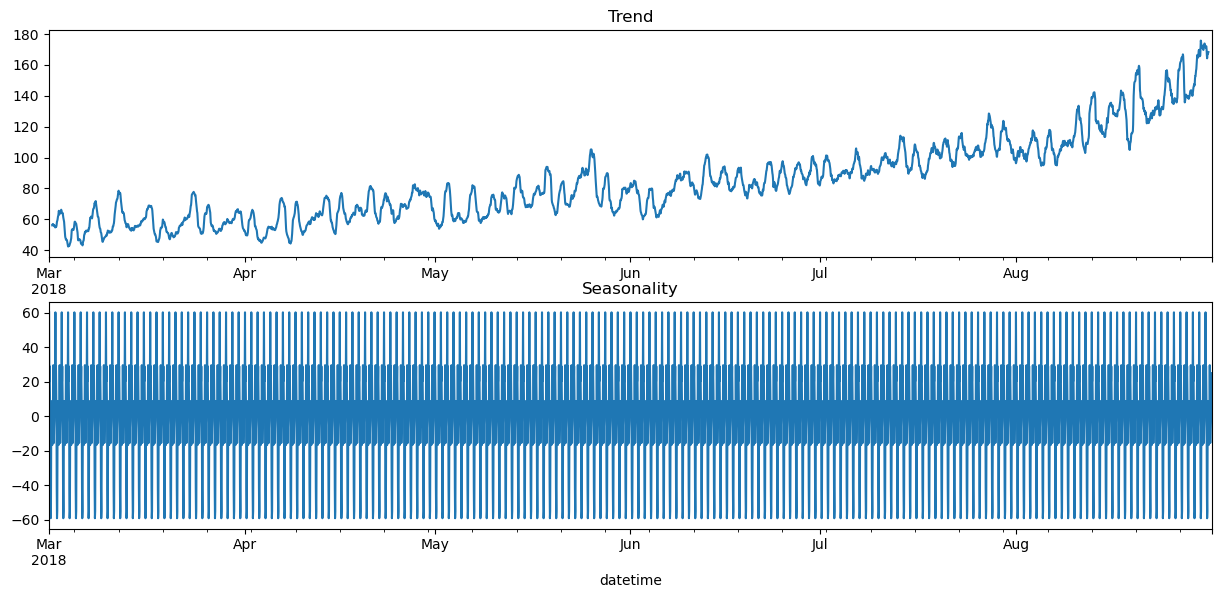

In [9]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

Провели декомпозицию временного ряда, чтобы посмотреть сезонность и тренд.

- График тренда показывает увеличение заказов такси в аэропорту с марта по август, при этом внутри каждого месяца есть пики и падения.  В начале марта заказов около 50 в день, в конце августа около 175 в день.
- Также мы видим постоянную сезонность, вероятно, связанную с выходными днями. Ниже построим график сезонности для одного любого месяца, чтобы рассмотреть подробнее.

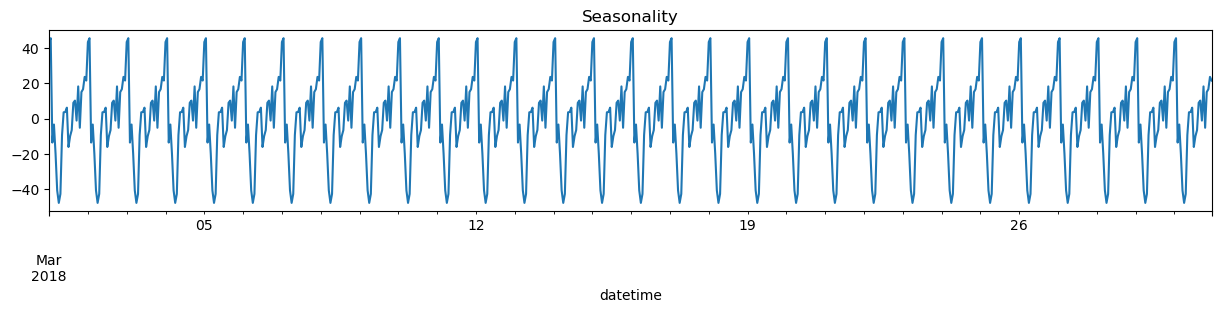

In [10]:
df_mar = df.copy()
df_mar = df_mar['2018-03-01':'2018-03-30']
decomposed = seasonal_decompose(df_mar)

plt.figure(figsize=(15, 8))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

На графике сезонности марта прослеживаются колебания, связанные с временем суток. Вероятно, количество вызываемых такси растет в ночные часы, когда не ходит общественный транспорт.

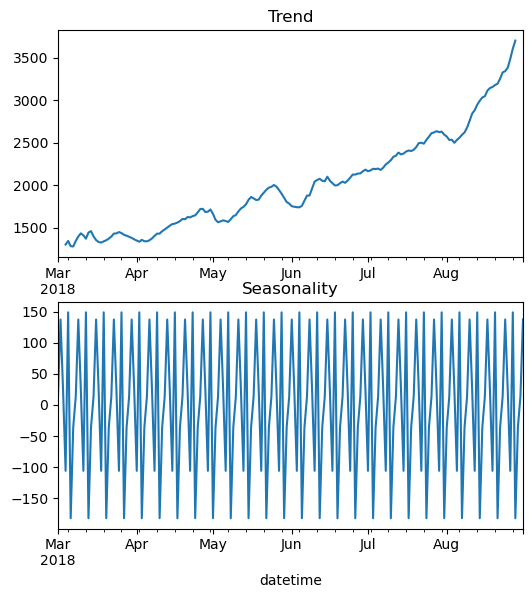

In [11]:
df_1 = df.copy()
df_1 = df_1.resample('1D').sum()

decomposed = seasonal_decompose(df_1)

plt.figure(figsize=(6, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

Также для анализа ресемплировали данные по одному дню в отдельный датасет. 

- График тренда показывает постепенное увеличение заказов такси в аэропорту с марта по август, с пиком в конце августа. В начале марта заказов около 1000 в день, в конце августа около 3500.
- График сезонности показывает по 4 падения в каждом месяце. Что вероятно соответствует следующему дню после выходных. 

## Обучение моделей

### Преобразование RMSE через make_scorer

In [12]:
def rmse(predict, target):
    return (mean_squared_error(predict, target))**0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

### Разбиение данных на обучающую и тестовую выборки

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

Написали функцию преобразования датасета для задач обучения

In [14]:
df_new = make_features(df, 50, 1)

Преобразовали датасет, создав новый датасет df_new, который будем делить на выборки

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB


In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   year          4416 non-null   int64  
 2   month         4416 non-null   int64  
 3   day           4416 non-null   int64  
 4   dayofweek     4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-null   float64
 17  lag_13        4403 non-null

Проверили, что функция сработала корректно

In [17]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']  

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders'] 

Разделили новый датасет на обучающую и тестовую выборку 

### Линейная регрессия

In [18]:
model_lin = LinearRegression()
model_lin.fit(features_train, target_train)

rmse_lin = []
tscv = TimeSeriesSplit(n_splits=3)
rmse_lin = cross_val_score(model_lin, features_train, target_train, scoring = rmse_scorer, cv=tscv, n_jobs=-1) 
rmse_lin = - rmse_lin.mean()
print('Средняя оценка качества модели Линейная регрессия:',  rmse_lin)

Средняя оценка качества модели Линейная регрессия: 98.39390313523053


Обучили модель линейной регрессии. С помощью кросс-валидации получили среднее значение RMSE  = 98.4

### Случайный лес

In [19]:
best_model = None
best_result = 100
best_est = 0
best_depth = 0
for depth in range(2, 10):
    for est in range(1, 100, 10):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        tscv = TimeSeriesSplit(n_splits=3)
        model.fit(features_train, target_train) 
        scores = cross_val_score(model, features_train, target_train, scoring = rmse_scorer,  cv=tscv, n_jobs=-1) 
        result =  -scores.mean()
        if result < best_result:
            best_model = model
            best_result =  result 
            best_est = est
            best_depth = depth
rmse_for = best_result
model_for = best_model
print('Средняя оценка качества модели Случайный лес:',  rmse_for, 'n_estimators:',  best_est, 'depth', best_depth)

Средняя оценка качества модели Случайный лес: 26.134285070896457 n_estimators: 91 depth 9


Обучили модель Случайного леса с подбором гиперпараметров и оценкой на кросс-валидации. Лучшая модель выдала среднее RMSE = 26.1

### Градиентный бустинг LGBMRegressor

In [20]:
best_model = None
best_result = 100
best_est = 0
best_depth = 0
for depth in range(2, 10):
    for est in range(1, 100, 10):
        model = LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        tscv = TimeSeriesSplit(n_splits=3)
        scores = cross_val_score(model, features_train, target_train, scoring = rmse_scorer,  cv=tscv, n_jobs=-1) 
        result =  -scores.mean()
        if result < best_result:
            best_model = model
            best_result =  result 
            best_est = est
            best_depth = depth
rmse_gbm = best_result
model_gbm = best_model
print('Средняя оценка качества модели Градиентный бустинг LGBMRegressor:',  rmse_gbm, 'n_estimators:',  best_est, 'depth', best_depth)

Средняя оценка качества модели Градиентный бустинг LGBMRegressor: 25.472230817035825 n_estimators: 91 depth 3


Обучили модель градиентого бустинга LGBMRegressor, с помощью кросс-валидации. Средняя оценка лучшей модели RMSE = 25.5

### Градиентный бустинг CatBoostRegressor

In [21]:
model_cat = CatBoostRegressor()
model_cat.fit(features_train, target_train)

best_model = None
best_result = 100
best_est = 0
best_depth = 0
for depth in range(2, 10):
    for est in range(1, 100, 10):
        model = CatBoostRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        tscv = TimeSeriesSplit(n_splits=3)
        scores = cross_val_score(model, features_train, target_train, scoring = rmse_scorer,  cv=tscv, n_jobs=-1) 
        result =  -scores.mean()
        if result < best_result:
            best_model = model
            best_result =  result 
            best_est = est
            best_depth = depth
rmse_cat = best_result
model_cat = best_model
print('Средняя оценка качества модели Градиентный бустинг CatBoostRegressor:',  rmse_cat , 'n_estimators:',  best_est, 'depth', best_depth)

Learning rate set to 0.050815
0:	learn: 37.7126379	total: 147ms	remaining: 2m 26s
1:	learn: 36.8301585	total: 163ms	remaining: 1m 21s
2:	learn: 35.9592224	total: 176ms	remaining: 58.5s
3:	learn: 35.1883910	total: 189ms	remaining: 47s
4:	learn: 34.4172103	total: 202ms	remaining: 40.2s
5:	learn: 33.7919325	total: 215ms	remaining: 35.6s
6:	learn: 33.1259671	total: 231ms	remaining: 32.8s
7:	learn: 32.5017000	total: 247ms	remaining: 30.7s
8:	learn: 31.8900086	total: 261ms	remaining: 28.7s
9:	learn: 31.3104152	total: 274ms	remaining: 27.1s
10:	learn: 30.8420385	total: 286ms	remaining: 25.8s
11:	learn: 30.3409655	total: 299ms	remaining: 24.6s
12:	learn: 29.9168054	total: 312ms	remaining: 23.7s
13:	learn: 29.5574275	total: 325ms	remaining: 22.9s
14:	learn: 29.1436761	total: 338ms	remaining: 22.2s
15:	learn: 28.7361241	total: 354ms	remaining: 21.8s
16:	learn: 28.3856277	total: 371ms	remaining: 21.5s
17:	learn: 28.0496417	total: 384ms	remaining: 20.9s
18:	learn: 27.7718457	total: 397ms	remaining

Обучили модель градиентого бустинга CatBoostRegressor, с помощью кросс-валидации.  Средняя оценка лучшей модели RMSE = 25.4 

### Вывод

По результатам обучения моделей получили следующие RMSE:

- Линейная регрессия = 98.4
- Случайный лес = 26.1 (n_estimators: 91 depth 9)
- Градиентный бустинг LGBMRegressor = 25.5 (n_estimators: 91 depth 3)
- Градиентный бустинг CatBoostRegressor = 25.4 (n_estimators: 81 depth 3)

Для работы и проверки на тестовой выборке будем использовать Градиентный бустинг  CatBoostRegressor, с лучшими показателями RMSE

## Проверить данные на тестовой выборке и сделать выводы..

In [22]:
pred_test_cat = model_cat.predict(features_test)
rmse_test_cat = (mean_squared_error(pred_test_cat, target_test))**0.5
rmse_test_cat

42.81723960787159

Проверили выбранную модель ( CatBoostRegressor) на тестовой выборке. Получили RMSE 42.8, это значение меньше 48, заданных условием задачи. Модель прошла проверку.

In [23]:
pred_test_cat_frame = pd.DataFrame(data=pred_test_cat)
target_test_frame = pd.DataFrame(data = target_test)

pred_test_cat_frame.index = target_test_frame.index

Сравним на графике предсказания и исходные данные тестовой выборки. Для этого:
- Преобразовали значения целевого признака на тестовой выборке и его предсказания в датафрэймы.
- Передали датафрейму предсказаний индекс из датасета тестовой выборки. 
- Построили графики тренда и сезонности

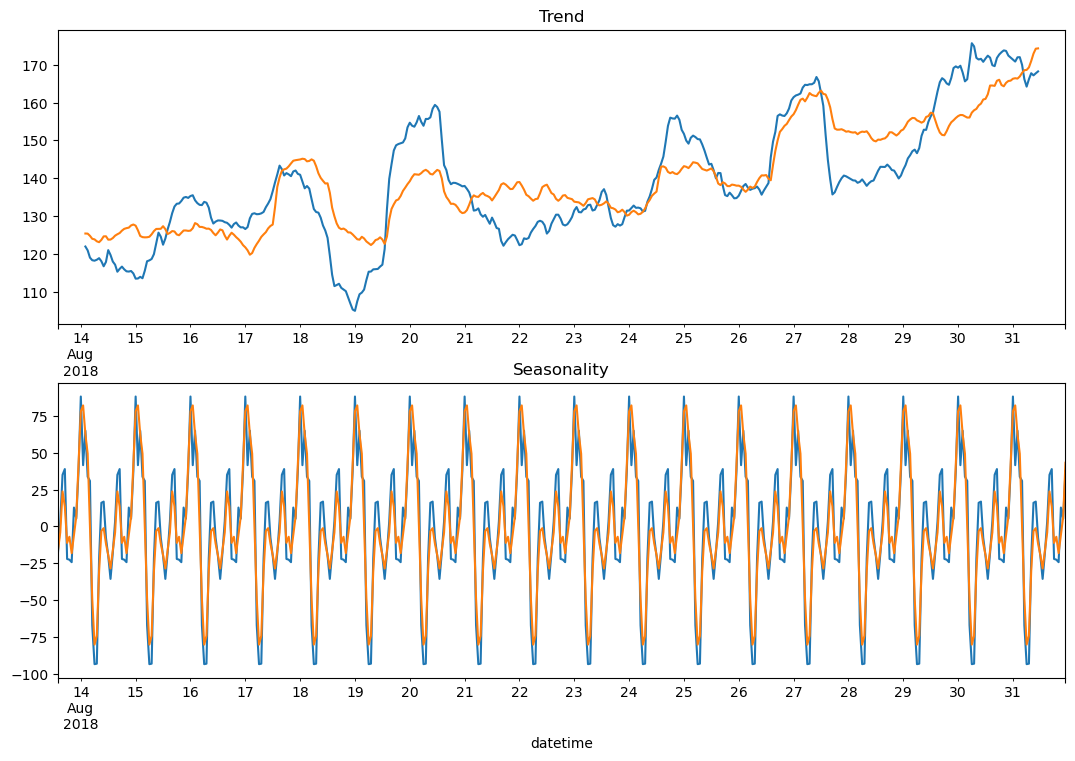

In [24]:
decomposed_target = seasonal_decompose(target_test_frame)
decomposed_pred = seasonal_decompose(pred_test_cat_frame)

plt.figure(figsize=(13, 13))
plt.subplot(311)
decomposed_target.trend.plot(ax=plt.gca())
decomposed_pred.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_target.seasonal.plot(ax=plt.gca())
decomposed_pred.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

**Вывод**

На графике сезонности видим, что предсказания очень близки к исходным. График тренда у предсказаний имеет общее направление с исходным временным рядом. В то же время, не успевает перестраиваться на взлеты и падения. Вероятно для более качественного обучения модели, нужны данные за несколько лет, так как сезонность она усваивает лучше. 